# CS3368, HW2 - SPRING 2024

1.   List item
2.   List item




## Topic: Sequential decision making with discrete state and action spaces.

In this assignment, you will solve MDP by **Value Iteration** and **Policy Iteration**
algorithms with a known dynamics and reward, $T$ and $R$, respectively.

The assignment has 2 parts. In Part-1, you are asked to fill in the blanks in the given code, and to complete the given tasks. In Part-2, you are asked to implement the Policy Iteration algorithm using tensor broadcasting (no for loops).

You can work in teams of 2 students. Please assign yourselves to the teams on BlackBoard.

You can discuss your solutions with other teams, but sharing your code or parts of it with other teams is plagiarism.

What to submit on Canvas: 1) a working notebook with the full solution, and 2) its corresponding PDF.


Due date : February 14, 2025, 11:59PM



# <h1><center> Part-1 </center></h1>

#### Import the necessary libraries:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import datetime
import random
%matplotlib inline

#### Design a maze:

In [ ]:
def get_maze(maze_file):
    '''
    : para1:  filename of the maze txt file
    : return: mazes as a numpy array walls: 0 - no wall, 1 - wall
    '''
    a = open(maze_file, 'r')
    m = []
    for i in a.readlines():
        m.append(np.array(i.split(" "), dtype="int32"))
    return np.array(m)

In [ ]:
# State Space
S = get_maze("my_maze_25x25.txt")
START = (1, 1)
GOAL = (24, 24)
# Action Space
A = [
    (-1, 0),    # 'up'
    (1, 0),     # 'down'
    (0, -1),    # 'left'
    (0, 1),     # 'right'
    (0, 0)      # 'stay'
]

# Noise
ALPHA = [0.2, 0.8]

# Maximum iterations
max_it = 100

In [ ]:
GRID_SIZE = len(S)
S[GOAL] = 3 # Goal state

#### Visualize the maze:

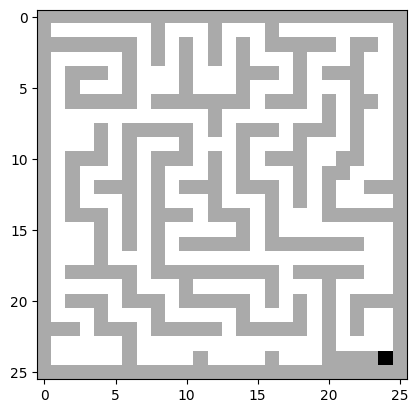

In [ ]:
plt.imshow(S, cmap='binary')

#### Define a utility function, s_next_calc, which computes the index of the next state given current state and action:

In [ ]:
def s_next_calc(s, a):
    '''
      This function returns the agent's next state given action and current state (assuming the action succeeds).
    : param s: Current position of the agent
    : param a: action taken by the agent
    : returns: New state coordinates in the grid
    '''
    return (s[0] + A[a][0], s[1] + A[a][1])

#### Define a utility function to check if the action at current state leads to a collision with a wall:

In [ ]:
def hit_wall(curr, action):
    '''
      This function checks if the agent hits any walls. Agent calculates "hitting the wall" with deterministic dynamics
    : param curr:   Current position of the agent
    : param action: Chosen action by the agent
    : returns:      True/False Binary value to indicate if agent hits a wall
    '''
    s_new = (curr[0] + A[action][0], curr[1] + A[action][1])

    # Check for grid boundaries
    if min(s_new) < 0 or max(s_new) > GRID_SIZE - 1:
        return True

    # Check walls
    # 0: 'up':   (-1,  0),
    # 1: 'down': ( 1,  0),
    # 2: 'left': ( 0, -1),
    # 3: 'right':( 0,  1),
    # 4: 'stay': ( 0,  0)
    if (S[curr] == 0 and S[s_new] == 1):
        return True

    return False

#### Define the reward function:

In [ ]:
def R(s, a):
    '''
      Reward function
    : param s: Current state of the agent
    : param a: Action the agent takes at the current state
    : returns: Reward for the action at current state
    '''
    if s == GOAL:
        return 0
    elif hit_wall(s, a):
        return -1000
    else:
        return -1

#### Calculate the transition probabilities to state s_next from current state s upon action a:

In [ ]:
def Pr(s_next, s, a, alpha):
    '''
      This function returns probabilities for each action at agent's current state.
    : param s_next:
    : param s:      Current state of the agent
    : param a:      Action the agent takes at the current state
    : param alpha:  Probability of the agent to take a random action instead of the action a
    : returns:      Transition probability for the action at current state
    '''
    # Can't move once reached the GOAL
    if s == GOAL:
        if s_next == s:
            return 1
        else:
            return 0

    # If wall hit, next state is current state
    if hit_wall(s, a):
        # Legal action with s = s'
        if s_next == s:
            return 1
        # Illegal action with s != s'
        else:
            return 0

    # Legal action with adjacent s and s'
    if s_next == s_next_calc(s, a):
        return 1 - alpha
    else:
        # Agent moves to another adjacent state instead of s' due to noise in a.
        # Generate all other neighbors of s by applying actions other than a.
        other_s_next = [s_next_calc(s, i) for i in range(len(A)) if i is not a]
        if s_next in other_s_next:
            return alpha / 4
    return 0

## Policy Iteration

In policy iteration, we define three functions:

* policy_evaluation
* policy_improvement
* policy_iteration

Refer to the lecture slides on policy iteration and value iteration.

In [ ]:
def policy_evaluation(policy, S, Pr, alpha, discount, theta, ctr):
    """
      This function computes expected cumulative reward for each state in the maze under a given policy.
    : param policy:   A map from the state space to the action space (numpy array with keys from S and values from A)
    : param S:        The state space (list of every tuple (x, y) for every position in the maze)
    : param Pr:       Transition function
    : param alpha:    Probability of performing an action other than the chosen one
    : param discount: Discount factor gamma
    : param theta:    Convergence threshold
    : param ctr:      Number of iterations
    """
    V = np.zeros((GRID_SIZE, GRID_SIZE))

    for _ in range(ctr):
        # Choose an initial delta value for the convergence test
        delta = 0
        V_prev = V.copy()

        for s, _ in np.ndenumerate(S):
            # Action by the policy
            a = policy[s]

            sum=0
            for action in range(len(A)):
                s_next = s_next_calc(s, action)
                if(s_next[0] > 25 or s_next[1] > 25):
                    continue
                sum += Pr(s_next, s, a, alpha) * V_prev[s_next]

            V[s] = R(s, a) + discount * sum
            # Convergence test
            delta = max(delta, abs(V[s] - V_prev[s]))

        if delta < theta: break

    return V, delta

In [ ]:
def policy_improvement(V, S, A, Pr, alpha, discount):

    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    policy_stable = True

    for s, _ in np.ndenumerate(S):

        old_action = policy[s]
        Q = np.zeros(len(A))

        for a in range(len(A)):
            # Update Q function at state, s, and action, a

            sum=0
            for action in range(len(A)):
                s_next = s_next_calc(s, action)
                if(s_next[0] > 25 or s_next[1] > 25):
                    continue
                sum += Pr(s_next, s, a, alpha) * V[s_next]

            Q[a] = R(s, a) + discount * sum

        # Update policy at state s
        policy[s] = np.argmax(Q)

        if old_action != policy[s]: policy_stable = False

    return policy, policy_stable

In [ ]:
def policy_iteration(S, A, Pr, alpha, discount, theta, n_eval, plot_enable, plot=None):
    """
    :param list S:         set of states
    :param list A:         set of actions
    :param function Pr:    transition function
    :param float alpha:    noise
    :param float discount: discount factor
    :param float theta:    tolerance, which determines when to end iterations
    :param int n_eval:     number of evaluations
    :param plot:           list of iteration numbers to plot
    """

    epsilon = 0

    #### For Task 4 ####
    start_time = 0
    end_time = 0
    time = 0
    total_time = 0
    ####################

    plt.ion()
    policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE))
    count = 0

    while True:

        start_time = datetime.datetime.now() # For Task 4

        V, delta = policy_evaluation(policy, S, Pr, alpha, discount, theta, n_eval)
        policy, policy_stable = policy_improvement(V, S, A, Pr, alpha, discount)

        # For Task 4
        end_time = datetime.datetime.now()
        time = (end_time - start_time).total_seconds() # Calculate time taken [seconds] for one iteration
        total_time += time

        # Plot intermediate result
        if (plot and count+1 in plot) and plot_enable:
            plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))

        if delta == 0:
            if plot_enable :
                plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            break

        if (delta > 0 and delta<=epsilon) or count==max_it or policy_stable:
            if(count == max_it):
                print('Policy iteration failed to converge for alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            if(plot_enable):
                 plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            break
        count=count+1

    return V, policy, count, total_time


## Value Iteration

We use the following function for value iteration. See slides starting from 61.

In [ ]:
def value_iteration(S, A, Pr, alpha, discount, plot_enable, plot=None):
    """
    :param list S:      set of states
    :param list A:      set of actions
    :param function Pr: transition function
    :param float alpha: noise
    :param float discount: discount factor
    """
    #### For Task 4 ####
    start_time = 0
    end_time = 0
    time = 0
    total_time = 0
    ####################

    plt.ion()

    V = np.zeros((GRID_SIZE, GRID_SIZE))
    V_prev = np.zeros((GRID_SIZE, GRID_SIZE))
    optimal_policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE), dtype=int)

    count = 0
    while True:

        start_time = datetime.datetime.now() # For Task 4

        delta = 0
        V_prev = V.copy()

        for s,_ in np.ndenumerate(S):

            Q = np.zeros(len(A))

            for a in range(len(A)):

                sum=0
                for action in range(len(A)):
                    s_next = s_next_calc(s, action)
                    if(s_next[0] > 25 or s_next[1] > 25):
                        continue
                    sum += Pr(s_next, s, a, alpha) * V_prev[s_next]

                Q[a] = R(s, a) + discount * sum   # expression for the Q function at state, s, and action, a

            V[s] = np.max(Q)
            delta = max(delta, abs(V[s] - V_prev[s])) # set the validation condition for the convergence
            # print(delta)

            optimal_policy[s] = np.argmax(Q)

        # For Task 4
        end_time = datetime.datetime.now()
        time = (end_time - start_time).total_seconds() # calculate time taken [seconds] for one iteration
        total_time += time


        # Plot current value and optimal policy
        if (plot and count+1 in plot) and plot_enable:
            plot_value_grid(V, optimal_policy, msg='Value iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            plt.pause(0.1)
        if delta <= 0 or count==max_it:
            if count == max_it:
                print('Value iteration failed to converge for alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            if(plot_enable):
                plot_value_grid(V, optimal_policy, msg='Value iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
                plt.pause(0.1)
            break
        count=count+1
    return V, optimal_policy, count, total_time


#### We will use the following utility function to plot the grid with values from V:

In [ ]:
def plot_value_grid(V, policy, msg=""):
    fig = plt.figure(figsize=(5, 5), tight_layout=True)
    plt.title(msg)
    plt.imshow(V)

    quiver_action_dict = [
            [1, 0],
            [-1, 0],
            [0, -1],
            [0, 1],
            [0, 0]
    ]
    for k, a in np.ndenumerate(policy):
        if(S[k] == 0): # Do not print the arrows on walls, to increase readibility
            q = plt.quiver(k[1], k[0], quiver_action_dict[a][1], quiver_action_dict[a][0])
    #fig.colorbar(q)
    plt.show()

## Tasks
### A. Find the optimal solution by two methods for  $\alpha$ = 0 (no noise).

### I. Policy Iteration

We are using iterative policy evaluation.

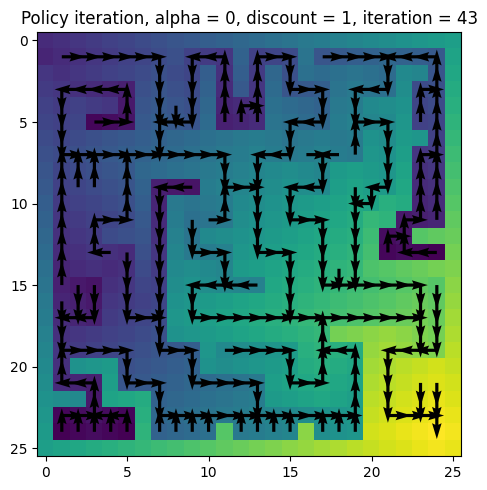

In [ ]:
n_pol_eval = 100 # number of policy evalutions
val2, pol2, pol_max_iter, time_taken = policy_iteration(S, A, Pr, alpha=0, discount=1, theta = 1e-6, n_eval=n_pol_eval, plot_enable = True)


### II. Value Iteration

Run for 100 iterations.
Plot the value function and the optimal policy, at iterations 1, 25, 50, 100.

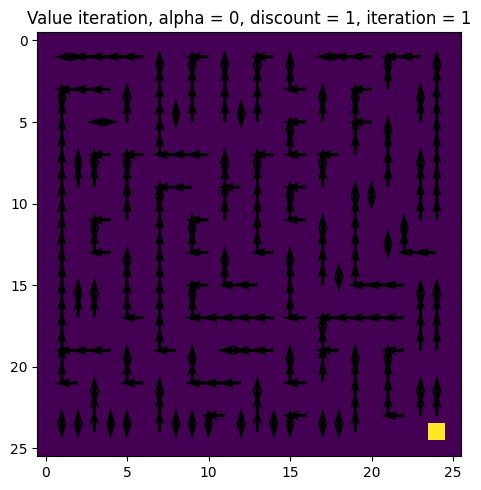

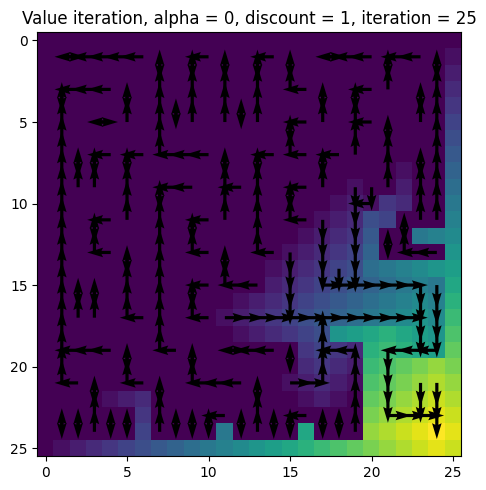

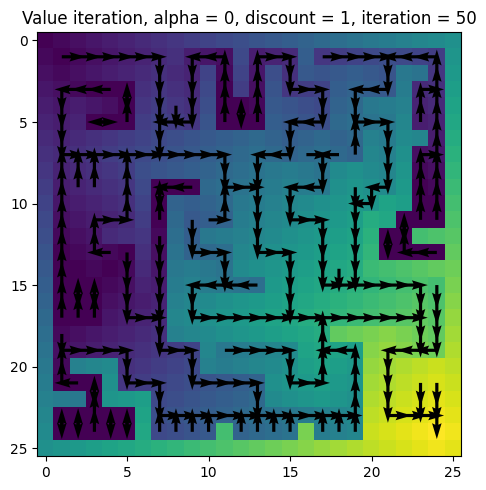

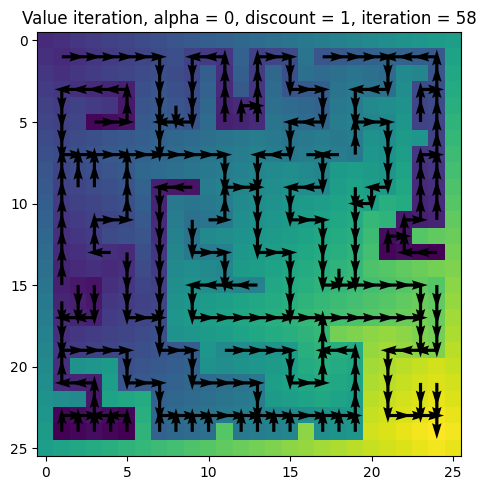

In [ ]:

val1, pol1, val_max_iter, time_taken = value_iteration(S, A, Pr, alpha=0, discount=1, plot_enable=True, plot=[1, 25, 50, 100])


Let's visualize these results

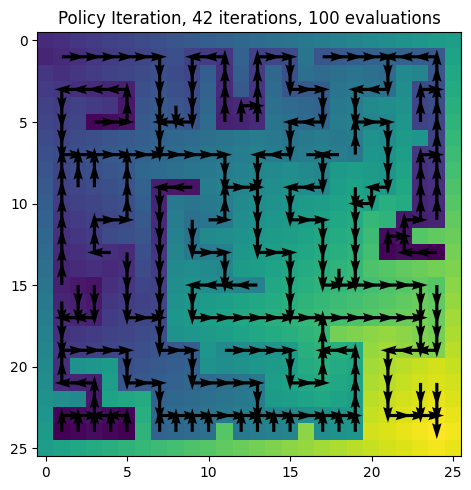

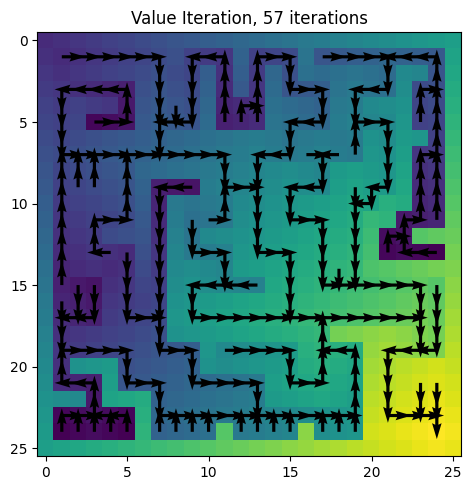

In [ ]:
# Plot for policy iteration alpha = 0, k_max = 100, run for 100 iterations
plot_value_grid(val2, pol2, msg='Policy Iteration, {} iterations, {} evaluations'.format(pol_max_iter, n_pol_eval))
# Plot for value iteration alpha = 0, 100 iterations
plot_value_grid(val1, pol1, msg='Value Iteration, {} iterations'.format(val_max_iter))

### III. Run Policy Iteration and Value Iteration for  five different discounted factors $\gamma \in \{0, 0.1, 0.4, 0.9, 1\}$ and perform the following tasks

1. Explain the change in utilities for different $\gamma$
2. Explain the change in optimal policies for different $\gamma$

#### Policy iteration for 𝛾∈{0,0.1,0.4,0.9,1} :

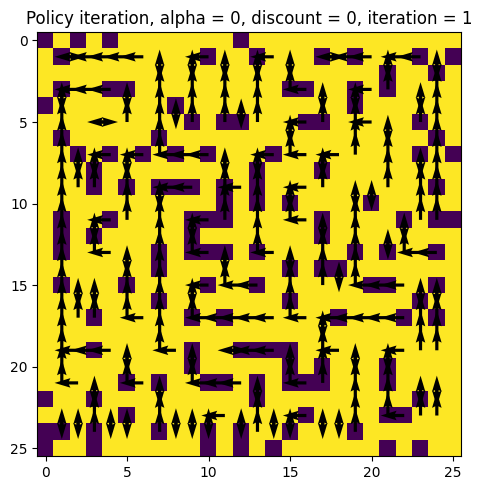

Policy iteration failed to converge for alpha = 0, discount = 0.1, iteration = 101


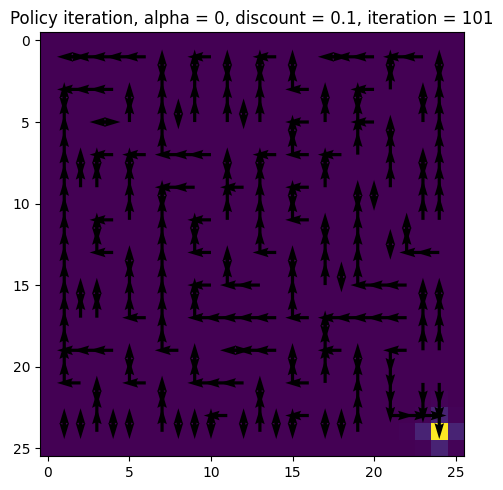

Policy iteration failed to converge for alpha = 0, discount = 0.4, iteration = 101


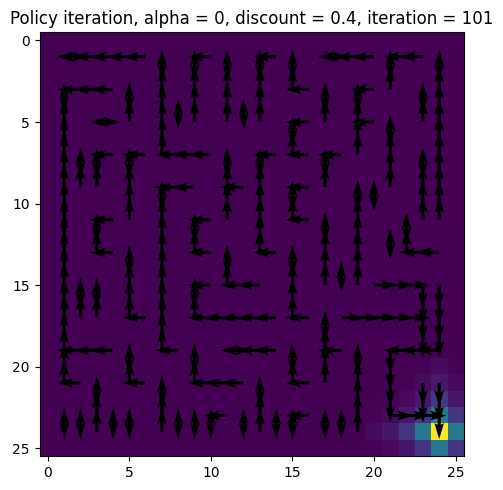

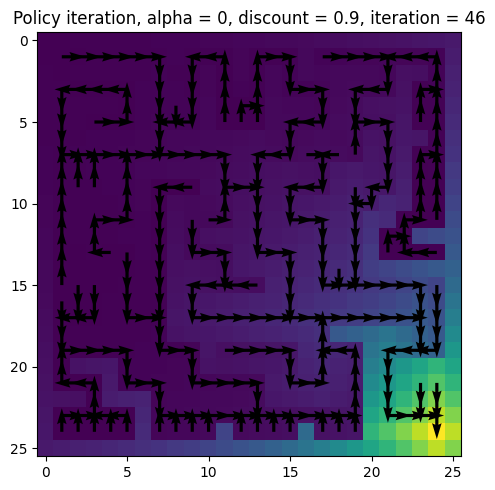

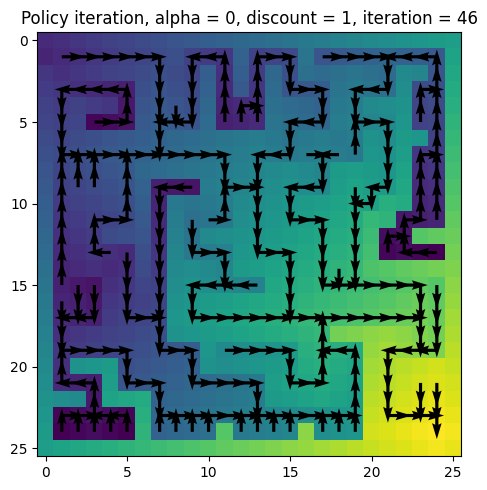

In [ ]:
n_pol_eval = 100 # number of policy evalutions
pol_time_list = []
for gamma in [0,0.1,0.4,0.9,1] :
    val2, pol2, pol_max_iter, comp_time = policy_iteration(S, A, Pr, alpha=0, discount=gamma, theta=1e-6, n_eval=n_pol_eval, plot_enable = True)
    pol_time_list.append(comp_time)
    plt.pause(0.1)

#### Value iteration for 𝛾∈{0,0.1,0.4,0.9,1} :

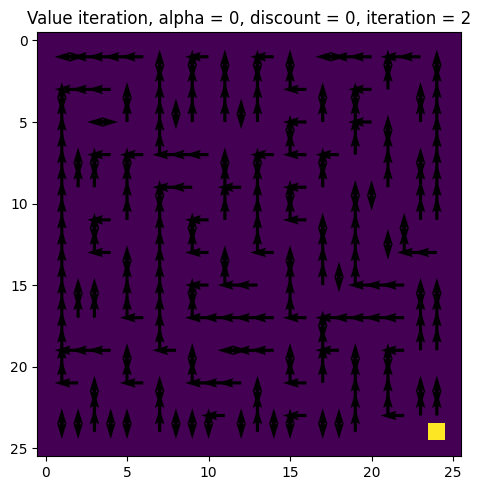

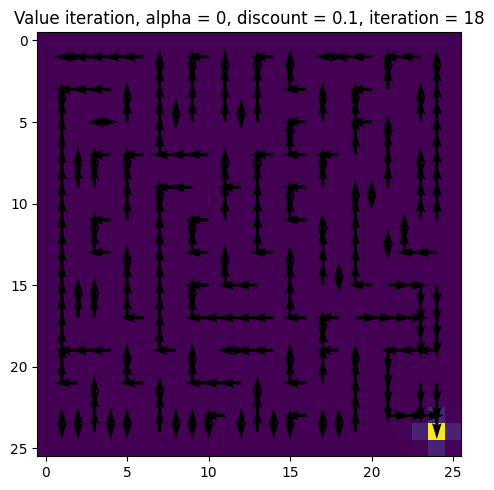

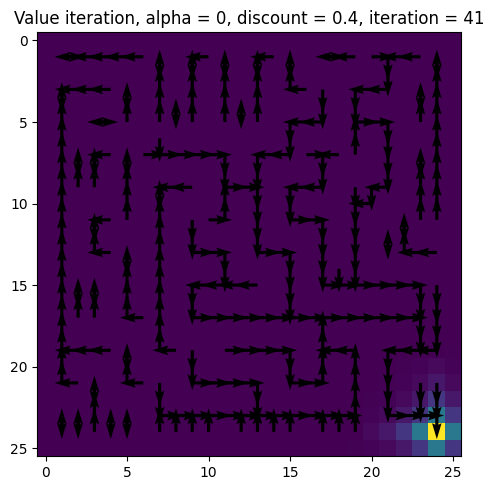

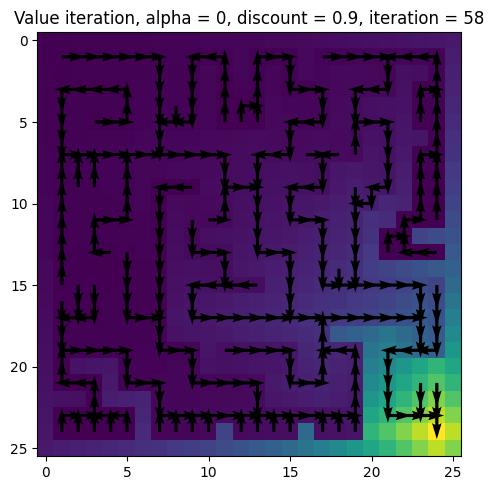

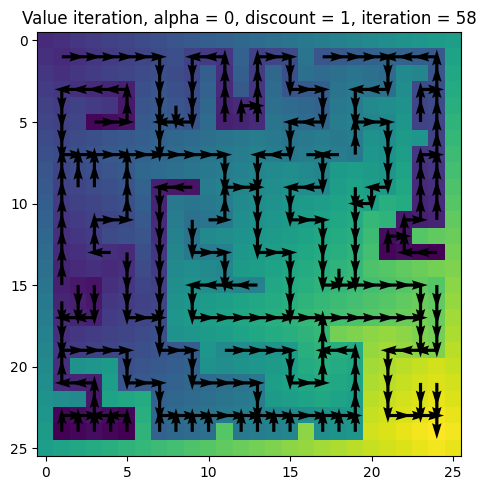

In [ ]:
n_pol_eval = 100 # number of policy evalutions
val_time_list = []
for gamma in [0,0.1,0.4,0.9,1] :
    val1, pol1, val_max_iter, comp_time = value_iteration(S, A, Pr, alpha=0, discount=gamma, plot_enable=True, plot=None)
    val_time_list.append(comp_time)
    plt.pause(0.1)

#### Your explanations:

### IV. Plot $\gamma$ VS computational time for the given $\gamma$ 's in Task 3:

#### 𝛾 VS computational time for Policy iteration :

Text(0.5, 1.0, 'Discount VS Computational time for Policy iteration')

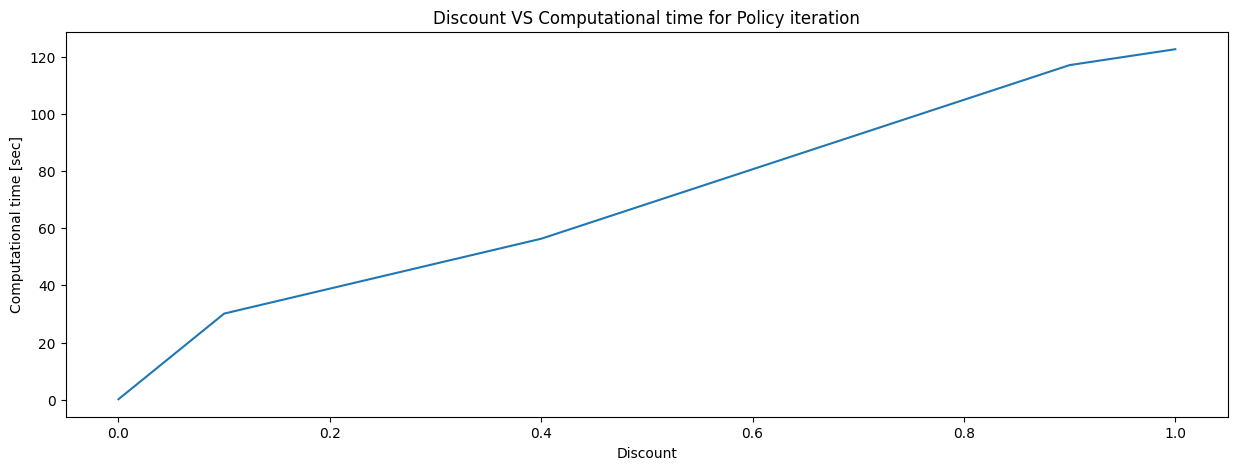

In [ ]:
fig = plt.figure(figsize=(15,5))

plt.xlabel('Discount')
plt.ylabel('Computational time [sec]')
plt.plot([0,0.1,0.4,0.9,1], pol_time_list)
plt.title('Discount VS Computational time for Policy iteration')

#### 𝛾 VS computational time for Value iteration :

Text(0.5, 1.0, 'Discount VS Computational time for Value iteration')

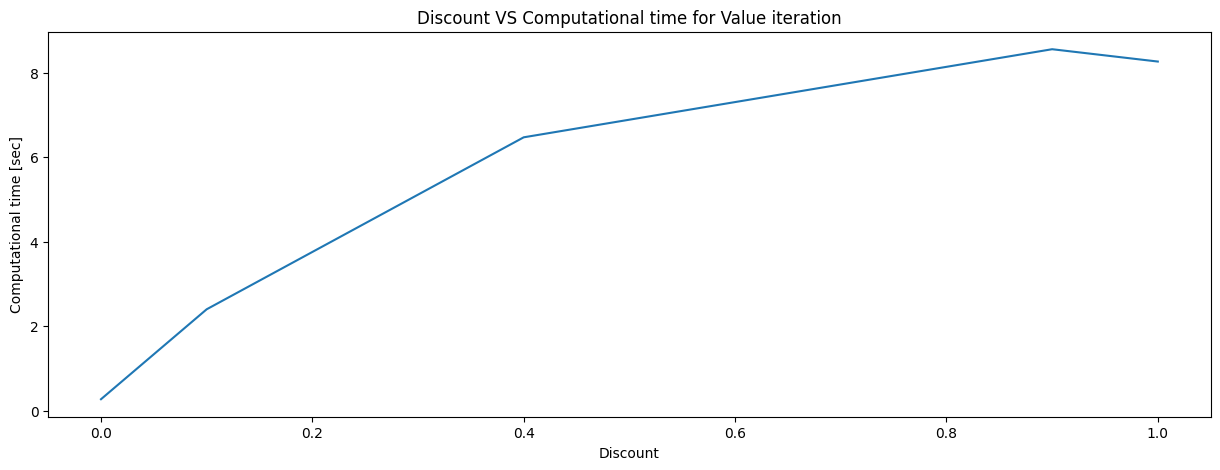

In [ ]:
fig = plt.figure(figsize=(15,5))

plt.xlabel('Discount')
plt.ylabel('Computational time [sec]')
plt.plot([0,0.1,0.4,0.9,1], val_time_list)
plt.title('Discount VS Computational time for Value iteration')

### B. Repeat Value and Policy iteration for 10, 20 and 100 iterations with $\alpha \in \{0.2, 0.8\}$

#### I. Policy Iteration

/usr/local/lib/python3.11/dist-packages/matplotlib/quiver.py:695: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.11/dist-packages/matplotlib/quiver.py:695: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


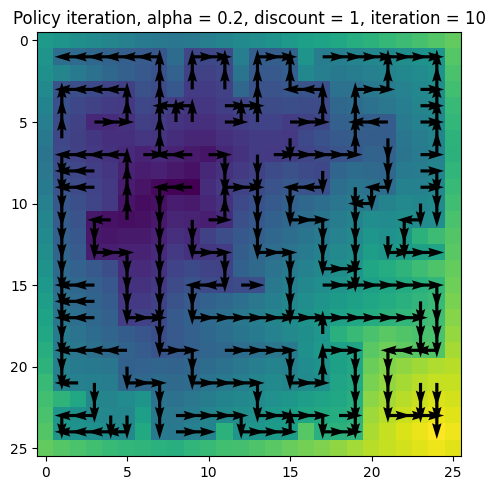

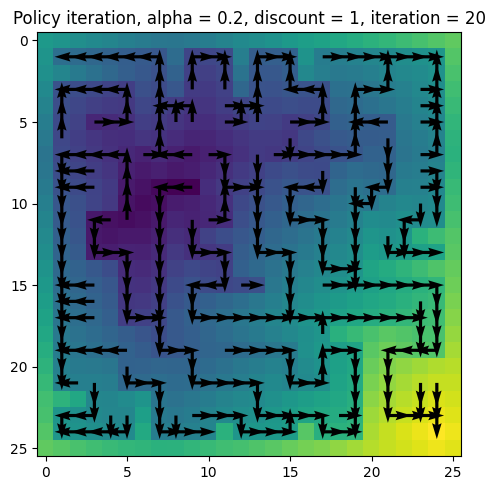

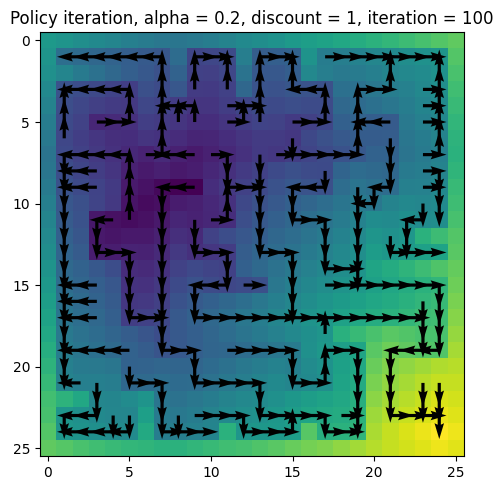

Policy iteration failed to converge for alpha = 0.2, discount = 1, iteration = 101


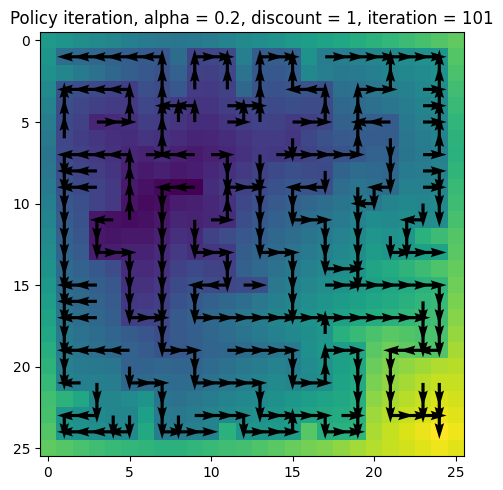

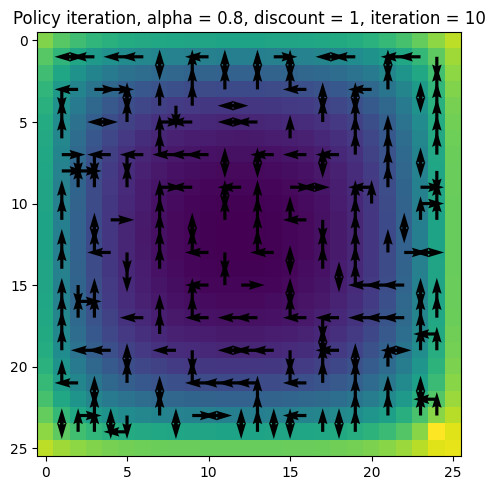

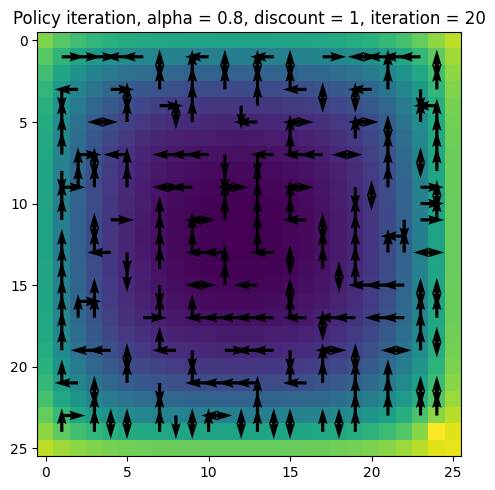

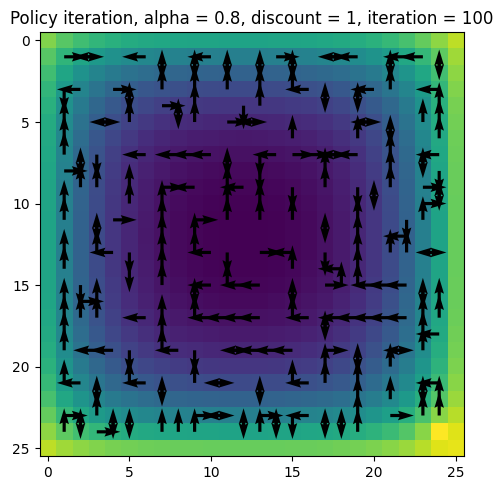

Policy iteration failed to converge for alpha = 0.8, discount = 1, iteration = 101


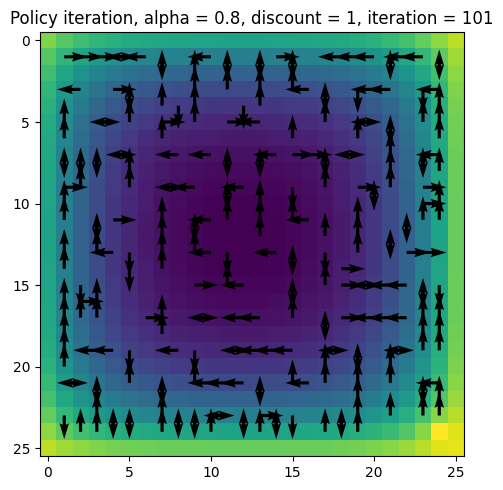

In [ ]:
for idx1, alpha in enumerate(ALPHA):
    val, pol, pol_iter, time_taken = policy_iteration(S, A, Pr, alpha=alpha, discount = 1, theta=1e-6, n_eval=100, plot_enable = True, plot=[10, 20, 100])

#### II. Value Iteration

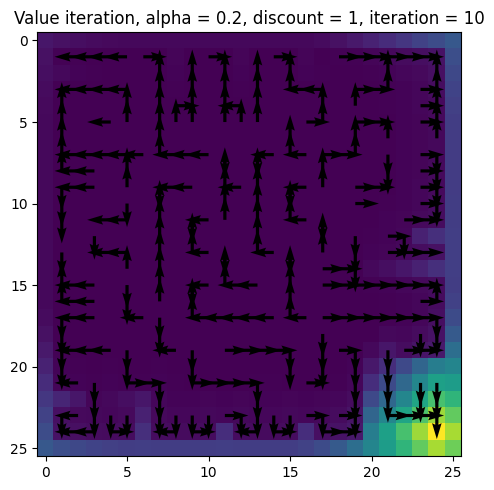

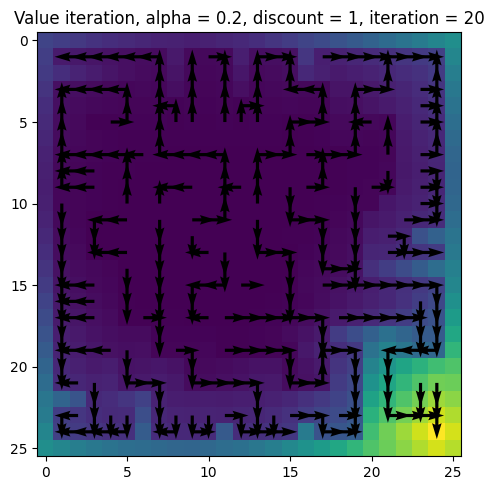

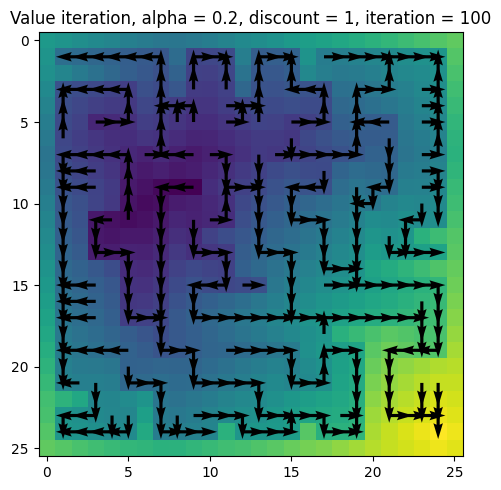

Value iteration failed to converge for alpha = 0.2, discount = 1, iteration = 101


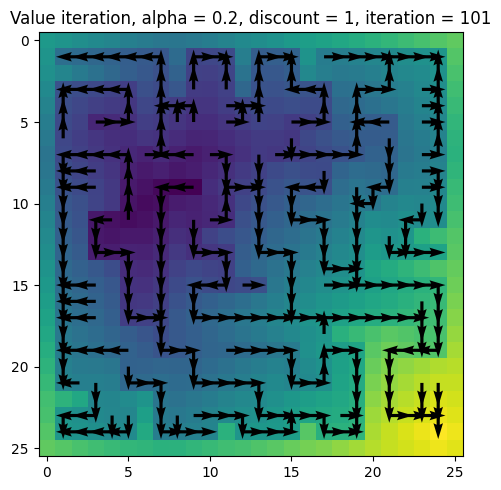

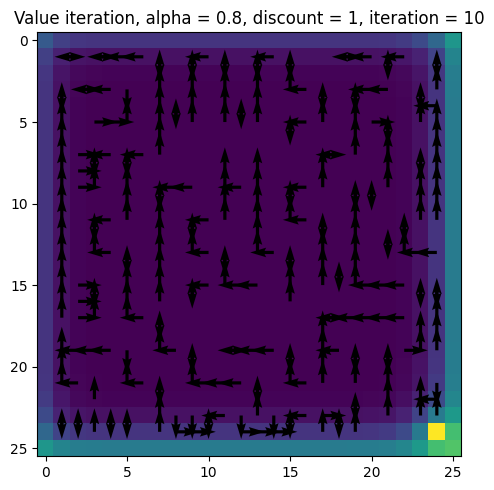

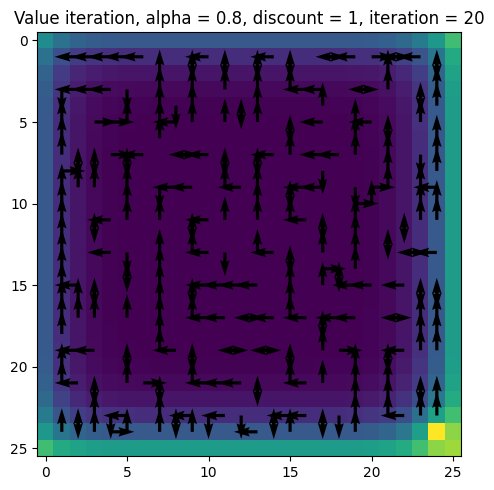

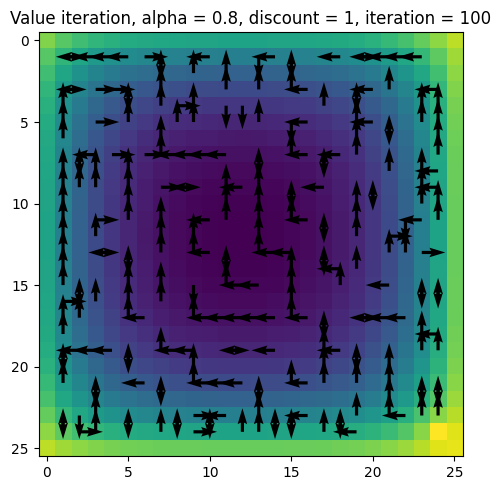

Value iteration failed to converge for alpha = 0.8, discount = 1, iteration = 101


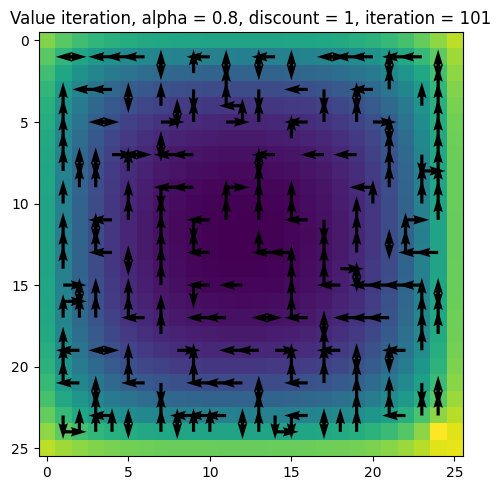

In [ ]:
for idx1, alpha in enumerate(ALPHA):
    val, pol, val_iter, comp_time = value_iteration(S, A, Pr, alpha = alpha, discount = 1, plot_enable=True, plot=[10, 20, 100])

**Summarize insights and your observations in Question B-I and B-II**

### C. Explain (up to 5 sentences) the differences between the approaches in HW1 (search, A*) and the approaches in the current assignment (MDP/Value/Policy)

## <h1><center> Part-2 </center></h1>

#### <h1><center> Utility functions to be implemented / PSEUDOCODE </center></h1>

Action space: Same as Part-1.
<br>
State space: Use the same maze as Part-1. You can use the get_maze() function from Part-1.
<br><br>
dS - size of the maze with dimensions: dS x dS
<br>
dA - number of actions
<br>
Goal - goal state.
<br><br>

PSEUDOCODE: function validState(s) =  returns true if (state, s, is within the maze boundaries) AND (s is NOT in the obstacles)

PSEUDOCODE: function BuildMaze(dS, dA, Goal):
<br>

	# dynamics tensor with dimensions: |dS| x |dS| x |dA| x |dS| x |dS| x 1, where the
	# dimensions are S₁, S₂, A, S₁′, S₂′. e.g., S₂ is the second coordinate of the current state, and S₁′ is the first coordinate of the state at the next time step.
	Ps′_sa = zeros(dS, dS, dA, dS, dS, 1)

	# the reward tensor with the same dimension as the dynamics
	# reward is 0 at the Goal state, -10000 if agent hits the wall, and -1 elsewhere.
	Rs′sa  = -ones(dS, dS, dA, dS, dS, 1)

	# iterate over the valid states
	for s in filter(validState, (x->x.I).(CartesianIndices((dS, dS))))
		if s ∈ Goal
			Ps′_sa[s..., :, s...] .= 1.0 # all the actions get prob 1 at the goal
			Rs′sa[s..., :, s...]  .= 0.0 # all the actions get reward 0
			continue
		end

		for a in Actions # the same action set at each state
			# if "next state is valid" move to it, otherwise stay at place
			s′ = validState(s .+ a[2]) ? s .+ a[2] : s
			Ps′_sa[s..., a[1], s′...] = 1.0
		end
	end
	"sanity test:" forall a, s : sum_s′ Ps′_sa = 1
	return Ps′_sa, Rs′sa
end


#### <h1><center> TASKS </center></h1>

### Placeholder for the definition of global variables, functions, etc

In [ ]:
def validState(s):
  if min(s) < 0 or max(s) > GRID_SIZE - 1:
        return False

  if (S[s] == 1):
        return False

  return True

In [ ]:
def buildMaze(dS, dA, GOAL):
  # dynamics tensor with dimensions: |dS| x |dS| x |dA| x |dS| x |dS| x 1, where the
  # dimensions are S₁, S₂, A, S₁′, S₂′. e.g., S₂ is the second coordinate of the current state, and S₁′ is the first coordinate of the state at the next time step.
  Ps_sa = np.zeros((dS, dS, dA, dS, dS, 1))

  # the reward tensor with the same dimension as the dynamics
  # reward is 0 at the Goal state, -10000 if agent hits the wall, and -1 elsewhere.
  Rs_sa = -1 * np.ones((dS, dS, dA, 1, 1, 1))
  Rs_sa[24, 24, :, 0, 0, 0] = 0

  # iterate over the valid states
  for s in filter(validState, [(x, y) for x in range(dS) for y in range(dS)]):
      if s == GOAL:
          Ps_sa[s[0], s[1], :, s[0], s[1], 0] = 1.0 # all the actions get prob 1 at the goal
          Rs_sa[s[0], s[1], :, 0, 0, 0] = 0.0 # all the actions get reward 0
          continue

      for a_idx in range(dA): # the same action set at each state

          # if "next state is valid" move to it, otherwise stay at place
          if validState((s[0] + A[a_idx][0], s[1] + A[a_idx][1])):
            s_next = (s[0] + A[a_idx][0], s[1] + A[a_idx][1])

          else:
            s_next = s
            Rs_sa[s[0], s[1], a_idx] = -10000

          Ps_sa[s[0], s[1], a_idx, s_next[0], s_next[1], 0] = 1.0

  for s in filter(validState, [(x, y) for x in range(dS) for y in range(dS)]):
    x, y = s
    for a1 in range(dA):
      prob_sum = 0
      for a2 in range(dA):
          s_next = s_next_calc((x,y), a2)
          if(max(s_next) > 25 or min(s_next) < 0):
              continue
          if Ps_sa[x, y, a1, s_next[0], s_next[1], 0] == 1:
            prob_sum += 1

      if (prob_sum != 1):
        print(f"Sanity Check Failed at state: ({x}, {y}). Probability adds to {prob_sum}.")


  return Ps_sa, Rs_sa

In [ ]:
def policy_evaluation_tensors(policy, Ps_sa, discount, theta, ctr, dS, dA):

    V = np.zeros((dS, dS, 1, 1, 1, 1))

    for i in range(ctr):

        # Choose an initial delta value for the convergence test
        delta = 0

        V_prev = np.transpose(V, axes=(3, 4, 2, 0, 1, 5))

        policies = policy[:, :, None, None, None, None]
        Ps_sa_pi = np.take_along_axis(Ps_sa, policies, axis=2)
        Rs_sa_pi = np.take_along_axis(Rs_sa, policies, axis=2)

        V = Rs_sa_pi + discount * np.sum(Ps_sa_pi * V_prev, axis=(3,4), keepdims=True)

        # Convergence test

        V_prev = np.transpose(V_prev, axes=(3, 4, 2, 0, 1, 5))

        delta = np.max(np.abs(V.squeeze() - V_prev.squeeze()))

        if delta < theta: break

    return V, delta

In [ ]:
def policy_improvement_tensors(policy, Ps_sa, discount, V, dS, dA):

    policy_stable = True

    old_policy = policy.copy()

    Q = np.zeros((dS, dS, dA, 1, 1, 1))

    V = np.transpose(V, axes=(3, 4, 2, 0, 1, 5))

    Q = Rs_sa + discount * np.sum(Ps_sa * V, axis=(3,4), keepdims=True)

    # Update policy at state s
    policy = np.argmax(Q.squeeze(), axis=2)

    if not np.array_equal(old_policy, policy):
      policy_stable = False

    return policy, policy_stable

In [ ]:
def policy_iteration_tensors(S, A, Rs_sa, Ps_sa, discount, theta, n_eval, plot_enable, plot=None):
    """
    :param list S:         set of states
    :param list A:         set of actions
    :param function Pr:    transition function
    :param float alpha:    noise
    :param float discount: discount factor
    :param float theta:    tolerance, which determines when to end iterations
    :param int n_eval:     number of evaluations
    :param plot:           list of iteration numbers to plot
    """

    epsilon = 0

    #### For Task 4 ####
    start_time = 0
    end_time = 0
    time = 0
    total_time = 0
    ####################

    plt.ion()
    policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE))

    dA = len(A)
    dS = GRID_SIZE

    count = 0

    while True:

        start_time = datetime.datetime.now() # For Task 4

        V, delta = policy_evaluation_tensors(policy, Ps_sa, discount, theta, n_eval, dS, dA)

        policy, policy_stable = policy_improvement_tensors(policy, Ps_sa, discount, V, dS, dA)

        # For Task 4
        end_time = datetime.datetime.now()
        time = (end_time - start_time).total_seconds() # Calculate time taken [seconds] for one iteration
        total_time += time

        # Plot intermediate result
        if (plot and count+1 in plot) and plot_enable:
            plot_value_grid(V[:, :, 0, 0, 0, 0], policy, msg='Policy iteration, discount = {}, iteration = {}'.format(discount, count+1))

        if delta == 0:
            if plot_enable :
                plot_value_grid(V[:, :, 0, 0, 0, 0], policy, msg='Policy iteration, discount = {}, iteration = {}'.format(discount, count+1))
            break

        if (delta > 0 and delta<=epsilon) or count==max_it or policy_stable:
            if(count == max_it):
                print('Policy iteration failed to converge for discount = {}, iteration = {}'.format(discount, count+1))
            if(plot_enable):
                 plot_value_grid(V[:, :, 0, 0, 0, 0], policy, msg='Policy iteration, discount = {}, iteration = {}'.format(discount, count+1))
            break
        count=count+1

    return V, policy, count, total_time


### Task 1 ###
Build your maze and visualize the maze layout on 2D plot.

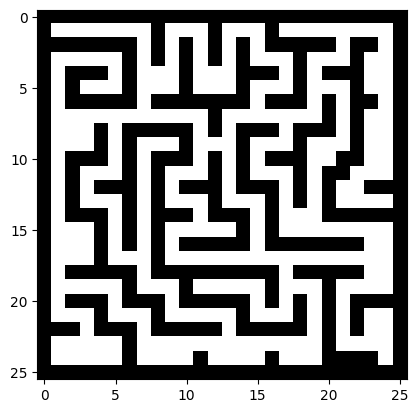

In [ ]:
S = get_maze("my_maze_25x25.txt")
plt.imshow(S, cmap='binary')

Ps_sa, Rs_sa = buildMaze(GRID_SIZE, 5, GOAL)

### Task 2 ###

Implement the Policy Evaluation (PE) algorithm for a deterministic policy, π.

Evaluate a random deterministic policy, π. Plot Value of a random policy on 2D plot.


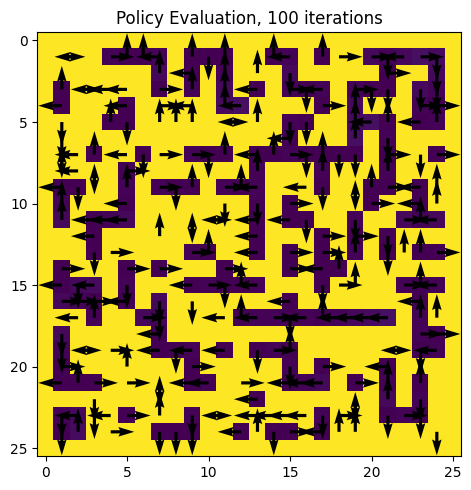

In [ ]:
policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE))

discount=1
theta = 1e-6
n_eval=100
dA=5
dS=26

V, delta = policy_evaluation_tensors(policy, Ps_sa, discount, theta, n_eval, dS, dA)

plot_value_grid(V[:, :, 0, 0, 0, 0], policy, msg='Policy Evaluation, {} iterations'.format(n_eval))

### Task 3 ###
Repeat Task 2 with manually setting the optimal actions in the radius of 2 states from the goal state.
Explain your observations.

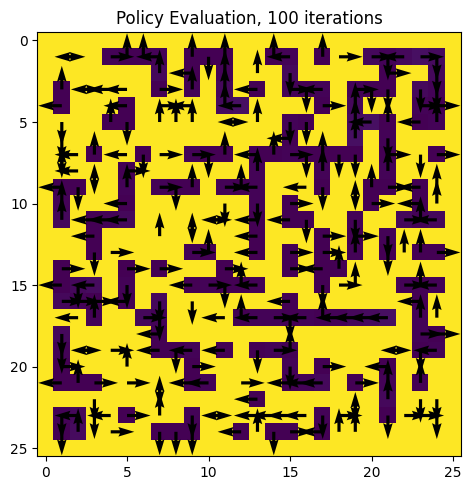

In [ ]:
policy[22,24] = 1
policy[23,23] = 3
policy[23,24] = 1
policy[24,24] = 4

V, delta = policy_evaluation_tensors(policy, Ps_sa, discount, theta, n_eval, dS, dA)

plot_value_grid(V[:, :, 0, 0, 0, 0], policy, msg='Policy Evaluation, {} iterations'.format(n_eval))

#### Your observations:

When we manually set the optimal actions in the radius of two states from the goal state, we observe that this results in a higher value propagation in the area surrounding the goal state. In the Task 3 output, we observe that the states near the goal state change from purple to yellow representing the change in value.

### Task 4 ###
Implement the Policy Iteration (PI) Algorithm, and find the optimal policy $π^*$.
Visualize the optimal value function, V_i, on a 2D plot at 3 different iterations, i, of PI.
Explain your observations.

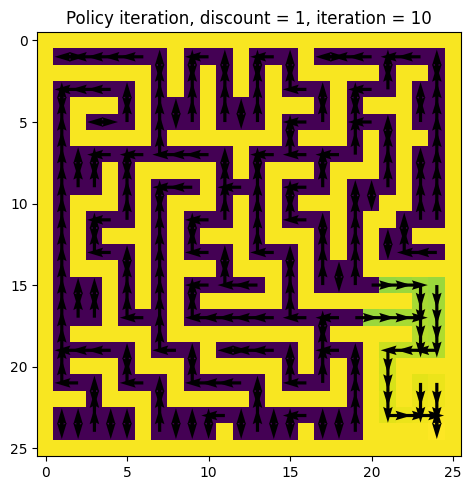

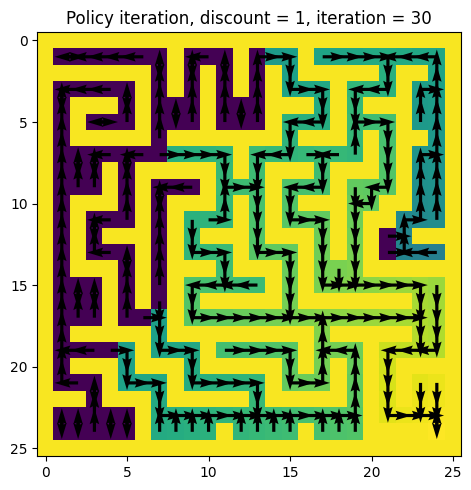

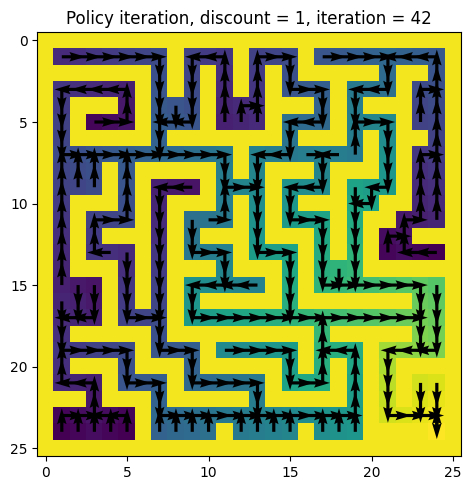

In [ ]:
n_eval = 100 # number of policy evalutions
discount = 1
theta = 1e-6
plot_enable = True

value, policy, pol_max_iter, time_taken = policy_iteration_tensors(S, A, Rs_sa, Ps_sa, discount, theta, n_eval, plot_enable, plot=[10, 30, 100])

#### Your observations:

When visualizing the Value function at iterations 10, 30, 46, we observe significant changes as the policy becomes more structured and the value function becomes more evenly distributed with clearer gradients. At iteration 10, we see that the policy is mostly inconsistent and the value function is purple for the majority of the maze. At iteration 30, we observe about half the policy showing structured paths, and for the value function we observe new colors other than purple and yellow. At iteration 46, the policy and value function have fully converged. The value function is represented by wide distribution of colors.